<a href="https://colab.research.google.com/github/miguel-rg/dynamical-loss-functions/blob/main/Updated_dynamical_loss_functions_for_machine_learning_github_no_NTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tilting the playing field: Dynamical loss functions for machine learning


This code reproduces Fig. 4 of our paper: "Tilting the playing field: Dynamical loss functions for machine learning"

We share it as a Colab notebook because it should be straightfoward to run.

Please, be aware this code is not optimized and its only purpose is to show the phenomenology discussed in the paper. 

Update (07/19/2022): Our code used [neural-tangents](https://github.com/google/neural-tangents) to create the neural network and to compute the NTK. However, a recent change in neural-tangents has disrupted the behavior of the neural network, affecting our results. As a temporary solution, we use jax.experimental instead of neural-tangents to create our neural network and recover the expected behavior. As a side effect, at the moment this code does not compute the NTK or the Hessian.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from matplotlib import gridspec
import pickle
import sys
from collections import namedtuple
import os

import jax
from jax import grad, jit
from jax.tree_util import tree_multimap

import jax.numpy as jnp
from jax import random
from jax.config import config
config.update("jax_enable_x64", True)

import numpy.random as npr
import seaborn as sns

Temporary solution:

In [2]:
from jax.experimental import stax

/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [3]:
### GLOBAL VARIABLES FOR THE SIMULATION ###

N = 100           #number of points per class
C = 3             #number of classes
NN_width = 100    #width of the NN
learning_rate = 1

## Shorter simulation, only two first cycles (faster to run) ##
T = 5000                     # time steps for one period
total_time = 10000            # total simulation time
last_period_no_osc = 0        # make A=1 for the last oscillation?

## Uncomment the following lines for the same simulation as in Fig. 4 (approx. 1 hour to run) ## 
T = 5000                      # time steps for one period
total_time = 70000            # total simulation time
last_period_no_osc = 1        # make A=1 for the last oscillation?


start_osc_from_the_middle = 0
time_comp_density = 25           # time step to compute Hessian eigenvalues 
order = 10                       # order of the Lanczos method

In [4]:
# Function to plot the results

def plot_all_together_5(W, L, L_weighted, A, limx_2_t = 100000,limx_1 = 8500, limx_2 = 10500):

    # defining some parameters
    markersize_t = 12
    number_eig = 1
    limy_w = 0.25
    limx_1_t = 0
    tick1 = 20
    tick2 = 5
    size_fig = 40
    poslet1 = 30
    poslet2 = 320
    fontsize = 60
    sns.set(context='talk', font_scale=3.5,  color_codes=True, palette='deep', style='ticks', 
            rc={"font.size":fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize, 'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 5.0})
    xlab = lambda name: plt.xlabel(name, fontsize=fontsize)
    ylab = lambda name: plt.ylabel(name, fontsize=fontsize)
    
    fig5 = plt.figure(figsize=(60,size_fig),constrained_layout=True)
    spec5 = fig5.add_gridspec(ncols=2, nrows=6, width_ratios=[6,1])


    ax = fig5.add_subplot(spec5[0, 0])
    W = np.array(W)
    colors_w = [np.array([176/256, 27/256, 42/256, 1]),'gold', 'darkblue']
    for ccc in range(3): 
        plt.plot(W[:,ccc],'.',c=colors_w[ccc],markersize=markersize_t)
    plt.xlim((limx_1_t,limx_2_t))
    ax.set_xticklabels([])
    plt.tick_params(which = 'both', direction='in', length=tick1, width=tick2)
    ylab('$\Gamma_i$')
    
    
    ax = fig5.add_subplot(spec5[0, 1])
    W = np.array(W)
    colors_w = [np.array([176/256, 27/256, 42/256, 1]),'gold', 'darkblue']
    for ccc in range(3): 
        plt.plot(W[:,ccc],'.',c=colors_w[ccc],markersize=markersize_t)
    plt.xlim((limx_1,limx_2))
    plt.tick_params(which = 'both', direction='in', length=tick1, width=tick2)
    ax.set_xticklabels([])

    ax = fig5.add_subplot(spec5[1, 0])
    plt.semilogy(L_weighted,'.' , markersize=markersize_t)
    plt.xlim((limx_1_t,limx_2_t))
    plt.tick_params(which = 'both', direction='in', length=tick1, width=tick2)
    ax.set_xticklabels([])
    ylab('$\mathcal{F}$')
    
    ax = fig5.add_subplot(spec5[1, 1])
    plt.plot(L_weighted,'.' , markersize=markersize_t)
    plt.ylim((0.2,0.6))
    plt.xlim((limx_1,limx_2))
    plt.tick_params(which = 'both', direction='in', length=tick1, width=tick2)
    ax.set_xticklabels([])
    
    ax = fig5.add_subplot(spec5[2, 0])
    plt.plot(np.array(L_weighted[:-1]) - np.array(L_weighted[1:]),'.' , markersize=markersize_t)
    plt.ylim((-limy_w,limy_w))
    plt.xlim((limx_1_t,limx_2_t))
    ax.set_xticklabels([])
    plt.tick_params(direction='in', length=tick1, width=tick2)
    ylab('$\mathcal{F}(t) - \mathcal{F}(t - 1)$')
    
    ax = fig5.add_subplot(spec5[2, 1])
    plt.plot(np.array(L_weighted[:-1]) - np.array(L_weighted[1:]),'.' , markersize=markersize_t)
    plt.ylim((-0.15,0.15))
    plt.xlim((limx_1,limx_2))
    plt.tick_params(direction='in', length=tick1, width=tick2)
    ax.set_xticklabels([])
  
    ax = fig5.add_subplot(spec5[3, 0])
    plt.plot(A,'.' , markersize=markersize_t)
    plt.xlim((limx_1_t,limx_2_t))
    plt.tick_params(direction='in', length=tick1, width=tick2)
    ylab('$Accuracy$') 
    xlab('$t$')
    
    ax = fig5.add_subplot(spec5[3, 1])
    plt.plot(A,'.' , markersize=markersize_t)
    plt.ylim((0.2,0.6))
    plt.xlim((limx_1,limx_2))
    xlab('$t$')
    plt.tick_params(direction='in', length=tick1, width=tick2)

    plt.show()


In [5]:
# Creating the dataset
def make_dataset(points_per_class, classes, revolutions=4):
  np.random.seed(0)

  N = points_per_class
  C = classes
  pi = np.pi

  X = np.zeros((N * C, 2))
  y = np.zeros((N * C, C))

  for j in range(C):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0., 1, N) # radius
    omega = 2 * pi / C
    theta_max = revolutions * pi
    t = np.linspace(omega * j,omega * j + theta_max, N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
    y[ix, j] = 1

  return jax.device_put(X), jax.device_put(y)

X, Y = make_dataset(points_per_class=N, classes=C)

In [6]:
### Defining the Neural Network ###

init_fn, apply_fn = stax.serial( stax.Dense(NN_width), 
                                           stax.Relu, 
                                           stax.Dense(3)
                                           )

key = random.PRNGKey(0)

# Weights for the loss function
def c_fn(t,i,w_max):
  slope = 2 * (w_max - 1) / T 
  w_main_class = jnp.where(t < T / 2., 1+ t * slope, 2 * w_max - t * slope - 1)
  res = jnp.ones(C) +  (w_main_class-1) * jnp.eye(C)[i]
  res = res / jnp.sum(res) * C
  return res

# Dynamical loss function
@jit
def weighted_loss(params, X, Y, t, i,w_max):
  w = c_fn(t,i,w_max)
  return -jnp.mean(jax.nn.log_softmax(apply_fn(params, X)) * Y * w) * C

# Standard loss function
@jit
def loss(params, X, Y):
  return -jnp.mean(jax.nn.log_softmax(apply_fn(params, X)) * Y) * C

# Accuracy
@jit
def accuracy(params, X, Y):
  return jnp.mean(jnp.argmax(apply_fn(params, X), axis=1) == jnp.argmax(Y, axis=1))

# Function that takes one minimization step
@jit
def step_CE(_, t_and_params_and_c):
  t, params, c, w_max = t_and_params_and_c
  g = grad(weighted_loss)(params, X, Y, t, c, w_max)
  return t + 1, tree_multimap(lambda x, dx: x - learning_rate * dx, params, g), c, w_max

In [7]:
### CODE TO COMPUTE THE EIGENVALUES OF THE HESSIAN USING THE LANCZOS ALGORITHM IN JAX ###
### this part of the code has been copied and modified from code by Justin Gilmer (https://github.com/google/spectral-density) ###

num_train = X.shape[0]
num_complete_batches, leftover = divmod(num_train, num_train)
num_batches = num_complete_batches + bool(leftover)

print('num_train,num_complete_batches, leftover,num_batches,bool(leftover)',num_train,num_complete_batches, leftover,num_batches,bool(leftover))

batch_size = np.shape(X)[0]
print('batch_size',batch_size)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield X[batch_idx], Y[batch_idx]

batches = data_stream()

batches_list = [next(batches) for i in range(num_batches)]
def batches_fn():
  for b in batches_list:
    yield b

num_train,num_complete_batches, leftover,num_batches,bool(leftover) 300 1 0 1 False
batch_size 300



  NEW SIMULATION A:  70 
 


/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


Period  0  finished. Time steps:  5001  Computation time:  62.7266800403595
Period  1  finished. Time steps:  5001  Computation time:  52.68200993537903
Period  2  finished. Time steps:  5001  Computation time:  50.38048815727234
Period  3  finished. Time steps:  5001  Computation time:  50.83367729187012
Period  4  finished. Time steps:  5001  Computation time:  50.90553021430969
Period  5  finished. Time steps:  5001  Computation time:  50.526978731155396
Period  6  finished. Time steps:  5001  Computation time:  51.16231918334961
Period  7  finished. Time steps:  5001  Computation time:  50.400569915771484
Period  8  finished. Time steps:  5001  Computation time:  50.43707013130188
Period  9  finished. Time steps:  5001  Computation time:  50.95208668708801
Period  10  finished. Time steps:  5001  Computation time:  50.37063717842102
Period  11  finished. Time steps:  5001  Computation time:  50.39344048500061
Period  12  finished. Time steps:  5001  Computation time:  50.9388151168

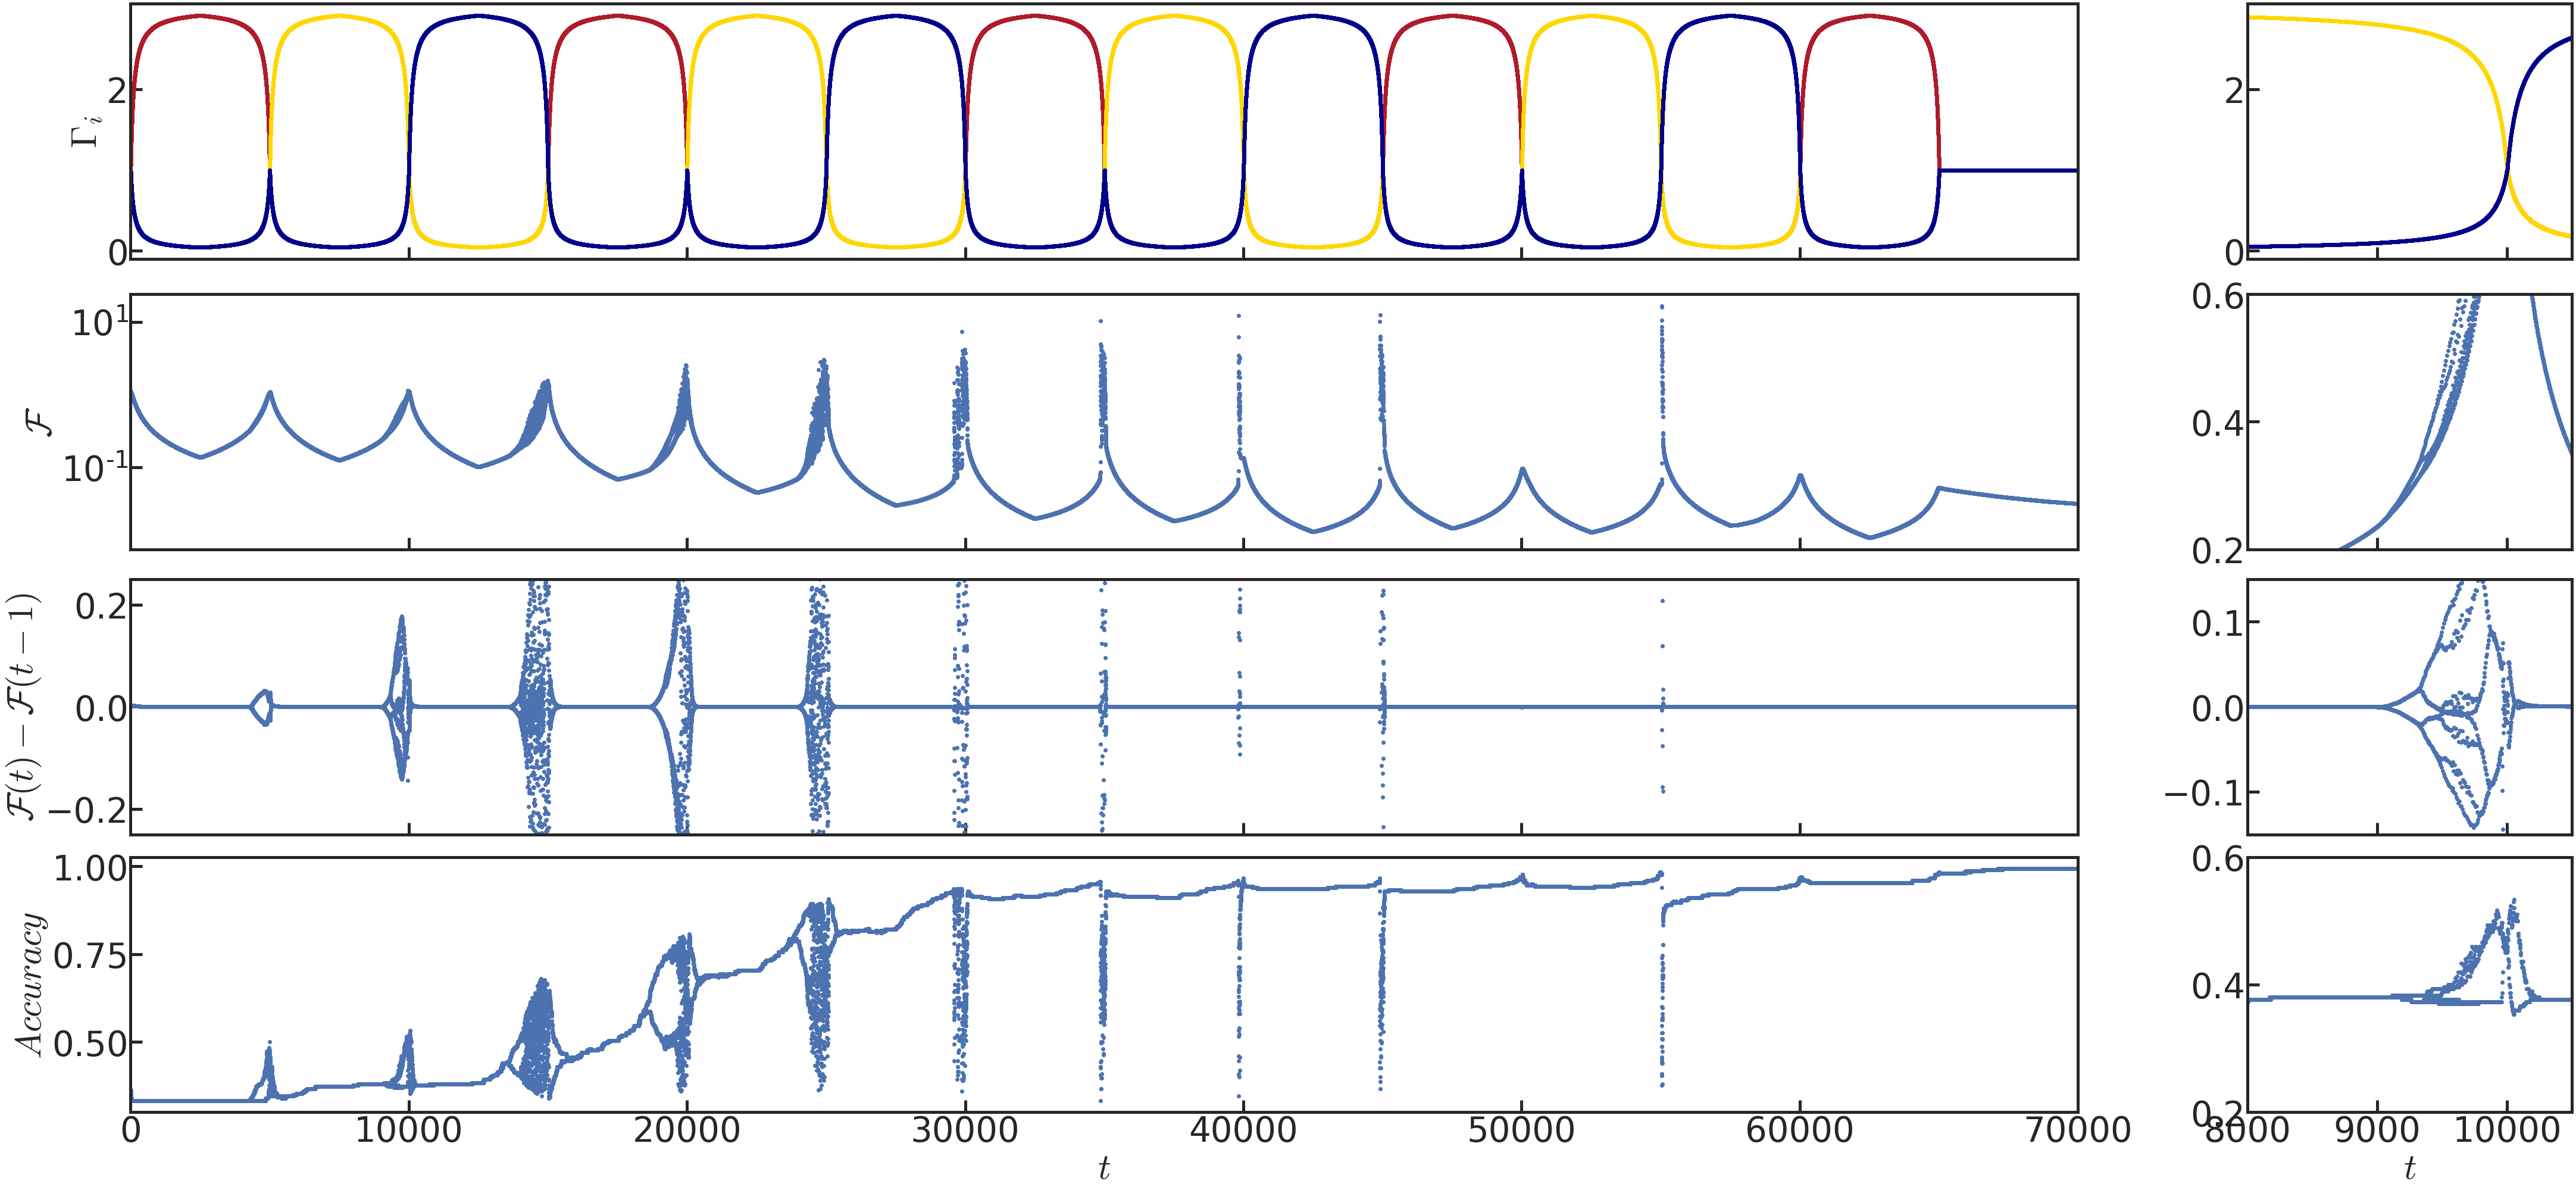

In [8]:
#######################
### TRAINING THE NN ###
#######################

w_max_list = [70] # A. It must be >= 1

for w_max in w_max_list:

  ind = 0

  print('\n ', 'NEW SIMULATION A: ', w_max, '\n ')

  L = []
  L_weighted = []
  A = []
  W = []

  if start_osc_from_the_middle:
    t = T // 2 
  else:
    t = 0

  c = 0

  ## NN initialization
  _, params = init_fn(key, X.shape)

  w_max_saved = w_max
  told = time.time()
  
  # Loop of minimization steps
  for i in range(total_time):

    if w_max <1:
      sys.exit('w_max must be >= 1')

    t, params, c, w_max = step_CE(0, (t, params, c, w_max)) 

    if t > T:
      # NEW CYCLE
      tnew = time.time()
      print('Period ',int(i%T) ,' finished. Time steps: ',t,' Computation time: ',tnew-told)
      told = tnew

      t = 0
      c = (c + 1) % 3

      if last_period_no_osc:
        if i>total_time-T:
          print('last period without oscillations')
          w_max = 1

      #Plot
      # plot_all_together_5(density, grids, NTK_EVALS, W, L, L_weighted, A, eigv_list_a, eigv_plot_times, limx_2_t = i, limx_1 = 1.6*T, limx_2 = 2.1*T)

    L += [loss(params, X, Y)]
    A += [accuracy(params, X, Y)]
    L_weighted += [weighted_loss(params, X, Y, t, c,w_max)]
    W += [c_fn(t,c,w_max)]

  plot_all_together_5(W, L, L_weighted, A, limx_2_t = total_time, limx_1 = 1.6*T, limx_2 = 2.1*T)